<img title="GitHub Octocat" src='./img/Octocat.jpg' style='height: 60px; padding-right: 15px' alt="Octocat" align="left"> This notebook is part of a GitHub repository: https://github.com/pessini/moby-bikes 
<br>MIT Licensed
<br>Author: Leandro Pessini

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import sys
import os

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models & Evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# statsmodel
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
import statsmodels.stats as stats

# Boost models
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
import catboost as cat
from catboost import CatBoostRegressor

from sklearn import metrics

# Hyperparameter optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Custom objects
sys.path.insert(0, os.path.abspath('../src/'))
import experiment_tracker as et

import time
import warnings
warnings.simplefilter('ignore', FutureWarning)
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
df_train = pd.read_csv('../data/processed/df_train.csv')
df_test = pd.read_csv('../data/processed/df_test.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rain                8760 non-null   float64
 1   temp                8760 non-null   float64
 2   rhum                8760 non-null   int64  
 3   wdsp                8760 non-null   int64  
 4   date                8760 non-null   object 
 5   hour                8760 non-null   int64  
 6   day                 8760 non-null   int64  
 7   month               8760 non-null   int64  
 8   year                8760 non-null   int64  
 9   count               8760 non-null   int64  
 10  holiday             8760 non-null   bool   
 11  dayofweek_n         8760 non-null   int64  
 12  dayofweek           8760 non-null   object 
 13  working_day         8760 non-null   bool   
 14  season              8760 non-null   object 
 15  peak                8760 non-null   bool   
 16  timeso

In [3]:
# creates a new object to keep track of the experiments
experiment_tracker = et.ExperimentTracker()

## Splitting data in train and test set

In [4]:
df = df_train.copy()
X = df.drop(['count'], axis=1)
y = df.pop('count')
all_columns = list(X.columns)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_val.shape

((6132, 22), (2628, 22))

In [5]:
test_df = df_test.copy()
X_test = test_df.drop(['count'], axis=1)
y_test = test_df.pop('count')
X_test.shape

(1464, 22)

In [6]:
idea_dummy = et.Idea(idea='Dummy Regressor', potential_outcome='To use as a baseline model, expected to perform badly.')
experiment_tracker.new_idea(idea_dummy)

--- New Idea added! ---
ID#: 5604533056 
Idea: Dummy Regressor 
Potential Outcome: To use as a baseline model, expected to perform badly.



In [7]:
def get_train_val_score(model, predictors, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val):
    
    X_train = X_train[[c for c in X_train.columns if c in predictors]]
    X_val = X_val[[c for c in X_val.columns if c in predictors]]
    model.fit(X_train, y_train)
    
    # Predict on training and validation set
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    
    # Calculate the RSME and MAE
    train_rsme = metrics.mean_squared_error(y_train, y_pred_train, squared=False) 
    # If squared = True returns MSE value, if False returns RMSE value.
    val_rsme = metrics.mean_squared_error(y_val, y_pred_val, squared=False)
    train_mae = metrics.mean_absolute_error(y_train, y_pred_train)
    val_mae = metrics.mean_absolute_error(y_val, y_pred_val)
    
    return train_rsme, val_rsme, train_mae, val_mae

In [8]:
def get_metrics_to_Experiment() -> list:
    rsme = et.Score('RSME', '{:.4f}'.format(train_rsme), '{:.4f}'.format(val_rsme))
    mae = et.Score('MAE', '{:.4f}'.format(train_mae), '{:.4f}'.format(val_mae))
    return [rsme, mae]

## Baseline Models

### Dummy Regressor

In [9]:
from sklearn.dummy import DummyRegressor
predictors = ['temp','rhum','wdsp','rain']
dummy_regr = DummyRegressor(strategy="mean")
train_rsme, val_rsme, train_mae, val_mae = get_train_val_score(dummy_regr, predictors)

In [10]:
exp_dummy_regr = et.Experiment('Dummy Regressor', predictors=predictors, hyperparameters=dummy_regr.get_params(), 
                               score=get_metrics_to_Experiment(), notes='Baseline Model for comparison')
experiment_tracker.add_experiment(exp_dummy_regr)

--- New Experiment added! ---
ID#: 5604190672 
Algorithm: Dummy Regressor 
Predictors: ['temp', 'rhum', 'wdsp', 'rain']
Hyperparameters: {'constant': None, 'quantile': None, 'strategy': 'mean'}
Date: 13/06/2022 23:18:06
Metric: [{ 'metric': RSME, 'train': 3.6138,  'validation': 3.5840, 'test': None }, { 'metric': MAE, 'train': 2.8752,  'validation': 2.9037, 'test': None }]
Notes: Baseline Model for comparison


### Linear Regression

In [11]:
idea_linear = et.Idea(idea='Linear Regression', potential_outcome='Expected to perform bad as we have many outliers and a count as target variable')
experiment_tracker.new_idea(idea_linear)

--- New Idea added! ---
ID#: 4607418528 
Idea: Linear Regression 
Potential Outcome: Expected to perform bad as we have many outliers and a count as target variable



In [12]:
from sklearn.linear_model import LinearRegression
predictors = ['temp','rhum','wdsp','rain']
lin_reg = LinearRegression()
train_rsme, val_rsme, train_mae, val_mae = get_train_val_score(lin_reg, predictors)
exp_lin_regr = et.Experiment('Linear Regression', predictors=predictors, hyperparameters='', 
                               score=get_metrics_to_Experiment(), notes='Linear Regression')
experiment_tracker.add_experiment(exp_lin_regr)

--- New Experiment added! ---
ID#: 4607412016 
Algorithm: Linear Regression 
Predictors: ['temp', 'rhum', 'wdsp', 'rain']
Hyperparameters: 
Date: 13/06/2022 23:18:06
Metric: [{ 'metric': RSME, 'train': 3.0883,  'validation': 3.0929, 'test': None }, { 'metric': MAE, 'train': 2.3738,  'validation': 2.4021, 'test': None }]
Notes: Linear Regression


In [13]:
experiment_tracker.update_idea(idea_linear, learnings='As expected the performance is not good as we have a lot of outliers and a count as target variable')

--- Idea updated! ---
ID#: 4607418528 
Idea: Linear Regression 
Potential Outcome: Expected to perform bad as we have many outliers and a count as target variable
Learnings: As expected the performance is not good as we have a lot of outliers and a count as target variable


### Random Forest

In [14]:
idea_random_forest = et.Idea(idea='Random Forest (only weather features)', potential_outcome='Expected to perform better than the Linear Regression')
experiment_tracker.new_idea(idea_random_forest)

--- New Idea added! ---
ID#: 5604536176 
Idea: Random Forest (only weather features) 
Potential Outcome: Expected to perform better than the Linear Regression



In [15]:
from sklearn.ensemble import RandomForestRegressor
predictors = ['temp','rhum','wdsp','rain']
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
train_rsme, val_rsme, train_mae, val_mae = get_train_val_score(rf, predictors)
exp_rf_regr = et.Experiment('Random Forest (only weather features)', predictors=predictors, hyperparameters=rf.get_params(), 
                               score=get_metrics_to_Experiment(), notes='')
experiment_tracker.add_experiment(exp_rf_regr)

--- New Experiment added! ---
ID#: 5604191344 
Algorithm: Random Forest (only weather features) 
Predictors: ['temp', 'rhum', 'wdsp', 'rain']
Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Date: 13/06/2022 23:18:08
Metric: [{ 'metric': RSME, 'train': 2.5369,  'validation': 3.0795, 'test': None }, { 'metric': MAE, 'train': 1.9659,  'validation': 2.3863, 'test': None }]



In [16]:
# update ideas with learnings
learnings = \
"""Random Forest with just a few hyperparameters performed just a little better than linear regression (validations score).
It seems to be overfitting as we see validation scores much higher than training scores. It's a sign that tuning hyperparameters is needed."""
experiment_tracker.update_idea(idea_random_forest, learnings=str.strip(learnings))

--- Idea updated! ---
ID#: 5604536176 
Idea: Random Forest (only weather features) 
Potential Outcome: Expected to perform better than the Linear Regression
Learnings: Random Forest with just a few hyperparameters performed just a little better than linear regression (validations score).
It seems to be overfitting as we see validation scores much higher than training scores. It's a sign that tuning hyperparameters is needed.


## Preprocessing Pipelines

In [17]:
import category_encoders as ce

def preprocessor(predictors: list) -> ColumnTransformer:
    # Setting remainder='passthrough' will mean that all columns not specified in the list of “transformers” 
    #   will be passed through without transformation, instead of being dropped

    ##################### Categorical variables #####################
    all_cat_vars = ['timesofday','dayofweek','holiday','peak','hour','working_day','season','month']
    cat_vars = [categorical_var for categorical_var in all_cat_vars if categorical_var in predictors]

    # categorical variables
    cat_pipe = Pipeline([
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

    cat_encoder = 'cat', cat_pipe, cat_vars

    ##################### Numerical variables #####################
    all_num_vars = ['rain', 'temp', 'rhum','wdsp','temp_r']
    num_vars = [numerical_var for numerical_var in all_num_vars if numerical_var in predictors]

    num_pipe = Pipeline([
        ('scaler', StandardScaler())
        # ('scaler', MinMaxScaler())
    ])

    num_enconder =  'num', num_pipe, num_vars

    ##################### Ordinal variables #####################
    all_ord_vars = ['wind_speed_group','rainfall_intensity']
    ord_vars = [ordinal_var for ordinal_var in all_ord_vars if ordinal_var in predictors]

    ordinal_cols_mapping = []
    if 'wind_speed_group' in predictors:
        ordinal_cols_mapping.append(
            {"col":"wind_speed_group",    
            "mapping": {
                'Calm / Light Breeze': 0, 
                'Breeze': 1, 
                'Moderate Breeze': 2, 
                'Strong Breeze / Near Gale': 3, 
                'Gale / Storm': 4
            }}
        )

    if 'rainfall_intensity' in predictors:
        ordinal_cols_mapping.append(
            {"col":"rainfall_intensity",    
            "mapping": {
                'no rain': 0, 
                'drizzle': 1, 
                'light rain': 2, 
                'moderate rain': 3, 
                'heavy rain': 4
            }}
        )

    # ordinal variables
    ord_pipe = Pipeline([
        ('ordinal', ce.OrdinalEncoder(mapping=ordinal_cols_mapping))
    ])

    ord_enconder =  'ordinal', ord_pipe, ord_vars
    
    #################################################################################
    
    orig_vars = [var for var in predictors if var not in cat_vars and var not in num_vars and var not in ord_vars]
    orig_enconder = 'pass_vars', 'passthrough', orig_vars
     # ['temp_bin','rhum_bin']
    # ord_pipe = 'passthrough'

    transformers_list = []
    transformers_list.append(cat_encoder) if cat_vars else None
    transformers_list.append(ord_enconder) if ord_vars else None
    transformers_list.append(num_enconder) if num_vars else None
    # transformers_list.append(orig_enconder) if orig_vars else None
    
    return ColumnTransformer(transformers=transformers_list, 
                             remainder='drop')

In [18]:
def plot_feature_importances(model, columns, X=X_val, y=y_val, plot_title='Feature Importances using permutation'):
    #Plotting features importance

    from sklearn.inspection import permutation_importance
    
    result = permutation_importance(
        model, X[columns], y, n_repeats=10, random_state=42, n_jobs=2
    )

    feat_importances = pd.Series(result.importances_mean, index=columns)
    feat_importances.sort_values(ascending=False, inplace=True)

    fig = plt.figure(figsize=(15, 12))
    sns.barplot(x=feat_importances.values, y=feat_importances.index, orient='h')
    plt.title(plot_title)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

    plt.show()

## Models

### Random Forest

In [19]:
idea_rf = et.Idea(idea='Random Forest with all expected features', potential_outcome='To use as a baseline model with all features.')
experiment_tracker.new_idea(idea_rf)

--- New Idea added! ---
ID#: 5605183056 
Idea: Random Forest with all expected features 
Potential Outcome: To use as a baseline model with all features.



In [20]:
predictors = ['temp_r','rhum','holiday','dayofweek','timesofday','wind_speed_group','rainfall_intensity','peak','working_day']
# random forest model
params_rf = {'n_estimators': 100,
             'max_depth': 10,
             'random_state': 42}

# Fit a pipeline with transformers and an estimator to the training data
pipe_rf = Pipeline([
    ('preprocessor', preprocessor(predictors)),
    ('model', RandomForestRegressor(**params_rf, criterion='squared_error'))
])

# pipe_rf.fit(X_train[predictors], y_train)
train_rsme, val_rsme, train_mae, val_mae = get_train_val_score(pipe_rf, predictors)
exp_rf_regr = et.Experiment('Random Forest with all expected features', predictors=predictors, hyperparameters=pipe_rf['model'].get_params(),
                               score=get_metrics_to_Experiment(), notes='Added all predictors and using preprocessing')
experiment_tracker.add_experiment(exp_rf_regr)

--- New Experiment added! ---
ID#: 4607427440 
Algorithm: Random Forest with all expected features 
Predictors: ['temp_r', 'rhum', 'holiday', 'dayofweek', 'timesofday', 'wind_speed_group', 'rainfall_intensity', 'peak', 'working_day']
Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Date: 13/06/2022 23:18:11
Metric: [{ 'metric': RSME, 'train': 2.2489,  'validation': 2.6988, 'test': None }, { 'metric': MAE, 'train': 1.6719,  'validation': 1.9974, 'test': None }]
Notes: Added all predictors and using preprocessing


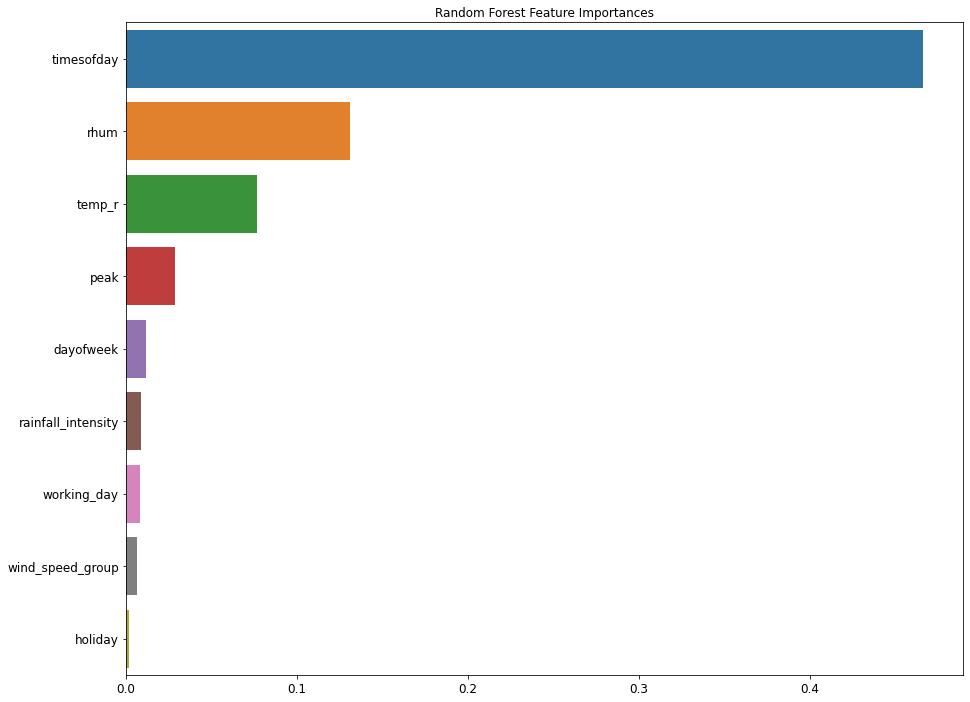

In [21]:
plot_feature_importances(model=pipe_rf, columns=predictors,plot_title='Random Forest Feature Importances')

In [22]:
learnings = \
"""Random Forest model with all features has decrease RSME and particularly in validation metrics."""
experiment_tracker.update_idea(idea_rf, learnings=str.strip(learnings))

--- Idea updated! ---
ID#: 5605183056 
Idea: Random Forest with all expected features 
Potential Outcome: To use as a baseline model with all features.
Learnings: Random Forest model with all features has decrease RSME and particularly in validation metrics.


In [23]:
idea_rf_cat = et.Idea(idea='Random Forest with all features as categorical', potential_outcome='Changing temp and hum to categorical variables it will improve the model\
    specifically the prediction with boosting trees.')
experiment_tracker.new_idea(idea_rf_cat)

--- New Idea added! ---
ID#: 5606353216 
Idea: Random Forest with all features as categorical 
Potential Outcome: Changing temp and hum to categorical variables it will improve the model    specifically the prediction with boosting trees.



In [24]:
predictors = ['temp_bin','rhum_bin','holiday','dayofweek','timesofday','wind_speed_group','rainfall_intensity','peak','working_day']
# random forest model
params_rf = {'n_estimators': 100, 
             'max_depth': 20, 
             'random_state': 0, 
             'min_samples_split' : 5,
             'n_jobs': -1}

# Fit a pipeline with transformers and an estimator to the training data
pipe_rf = Pipeline([
    ('preprocessor', preprocessor(predictors)),
    ('model', RandomForestRegressor(**params_rf, criterion='squared_error'))
])

train_rsme, val_rsme, train_mae, val_mae = get_train_val_score(pipe_rf, predictors)
exp_rf_regr = et.Experiment('Random Forest (all categoricals)', predictors=predictors, hyperparameters=pipe_rf['model'].get_params(),
                               score=get_metrics_to_Experiment(), notes='Added all predictors and using preprocessing')
experiment_tracker.add_experiment(exp_rf_regr)

--- New Experiment added! ---
ID#: 4607420448 
Algorithm: Random Forest (all categoricals) 
Predictors: ['temp_bin', 'rhum_bin', 'holiday', 'dayofweek', 'timesofday', 'wind_speed_group', 'rainfall_intensity', 'peak', 'working_day']
Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 20, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}
Date: 13/06/2022 23:18:26
Metric: [{ 'metric': RSME, 'train': 2.8120,  'validation': 2.8469, 'test': None }, { 'metric': MAE, 'train': 2.0633,  'validation': 2.1236, 'test': None }]
Notes: Added all predictors and using preprocessing


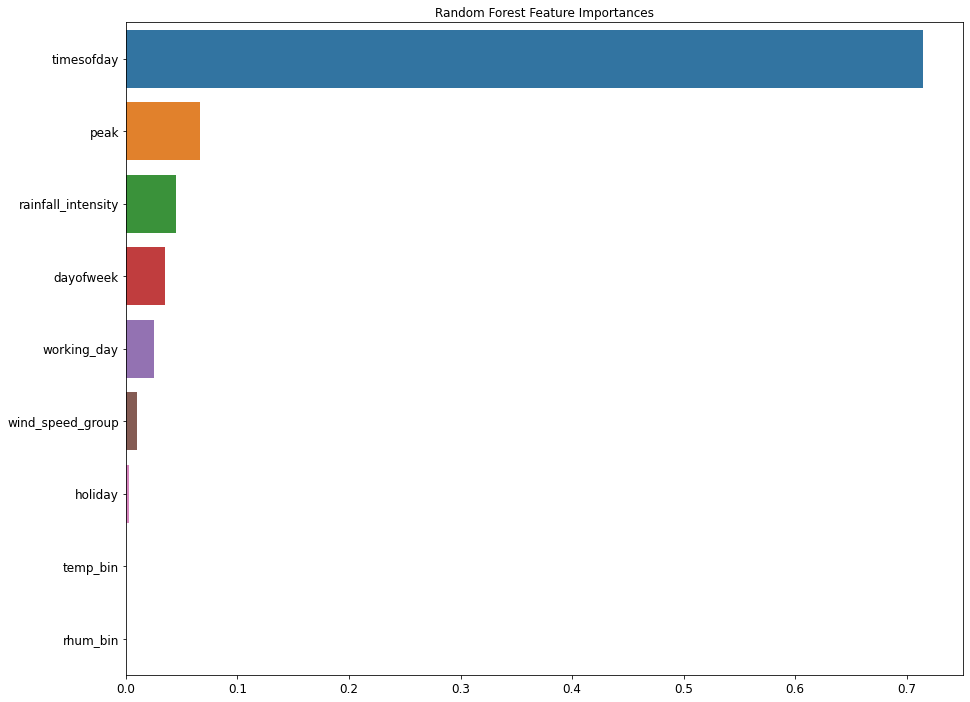

In [25]:
plot_feature_importances(model=pipe_rf, columns=predictors,plot_title='Random Forest Feature Importances')

In [26]:
learnings = \
"""Changing temp and hum into categorical variables did not improve the model. The expected improvement is for boosting models."""
experiment_tracker.update_idea(idea_rf_cat, learnings=str.strip(learnings))

--- Idea updated! ---
ID#: 5606353216 
Idea: Random Forest with all features as categorical 
Potential Outcome: Changing temp and hum to categorical variables it will improve the model    specifically the prediction with boosting trees.
Learnings: Changing temp and hum into categorical variables did not improve the model. The expected improvement is for boosting models.


In [27]:
# from IPython.display import display
# from sklearn import set_config
# set_config(display='diagram')
# display(pipe_rf)

## Catboost

In [28]:
idea_catboost = et.Idea(idea='Catboost', potential_outcome='Using all features as categorical variables it will perform better using boosting trees.')
experiment_tracker.new_idea(idea_catboost)

--- New Idea added! ---
ID#: 5606975808 
Idea: Catboost 
Potential Outcome: Using all features as categorical variables it will perform better using boosting trees.



In [29]:
predictors = ['temp_bin','rhum_bin','holiday','dayofweek','timesofday','wind_speed_group','rainfall_intensity','peak','working_day']
# random forest model
params_catboost = {'n_estimators': 100,
                   'random_state': 42,
                   'loss_function': 'RMSE',
                   'verbose': 25}

# Fit a pipeline with transformers and an estimator to the training data
pipe_catboost = Pipeline([
    ('preprocessor', preprocessor(predictors)),
    ('model', CatBoostRegressor(**params_catboost))
])

# fitparams_catboost = {'model__eval_set': (X_val[predictors], y_val)}
# pipe_catboost.named_steps.model.set_params(eval_set=(X_val, y_val))

train_rsme, val_rsme, train_mae, val_mae = get_train_val_score(pipe_catboost, predictors)
exp_catboost_regr = et.Experiment('Catboost model', predictors=predictors, hyperparameters=pipe_catboost['model'].get_params(),
                               score=get_metrics_to_Experiment(), notes='Added all categoricals features to use Catboost model.')
experiment_tracker.add_experiment(exp_catboost_regr)

Learning rate set to 0.310166
0:	learn: 3.3033477	total: 81.5ms	remaining: 8.07s
25:	learn: 2.8658136	total: 172ms	remaining: 490ms
50:	learn: 2.8378897	total: 262ms	remaining: 251ms
75:	learn: 2.8284177	total: 347ms	remaining: 110ms
99:	learn: 2.8218040	total: 440ms	remaining: 0us
--- New Experiment added! ---
ID#: 5607197280 
Algorithm: Catboost model 
Predictors: ['temp_bin', 'rhum_bin', 'holiday', 'dayofweek', 'timesofday', 'wind_speed_group', 'rainfall_intensity', 'peak', 'working_day']
Hyperparameters: {'loss_function': 'RMSE', 'verbose': 25, 'n_estimators': 100, 'random_state': 42}
Date: 13/06/2022 23:18:34
Metric: [{ 'metric': RSME, 'train': 2.8218,  'validation': 2.8131, 'test': None }, { 'metric': MAE, 'train': 2.0737,  'validation': 2.1020, 'test': None }]
Notes: Added all categoricals features to use Catboost model.


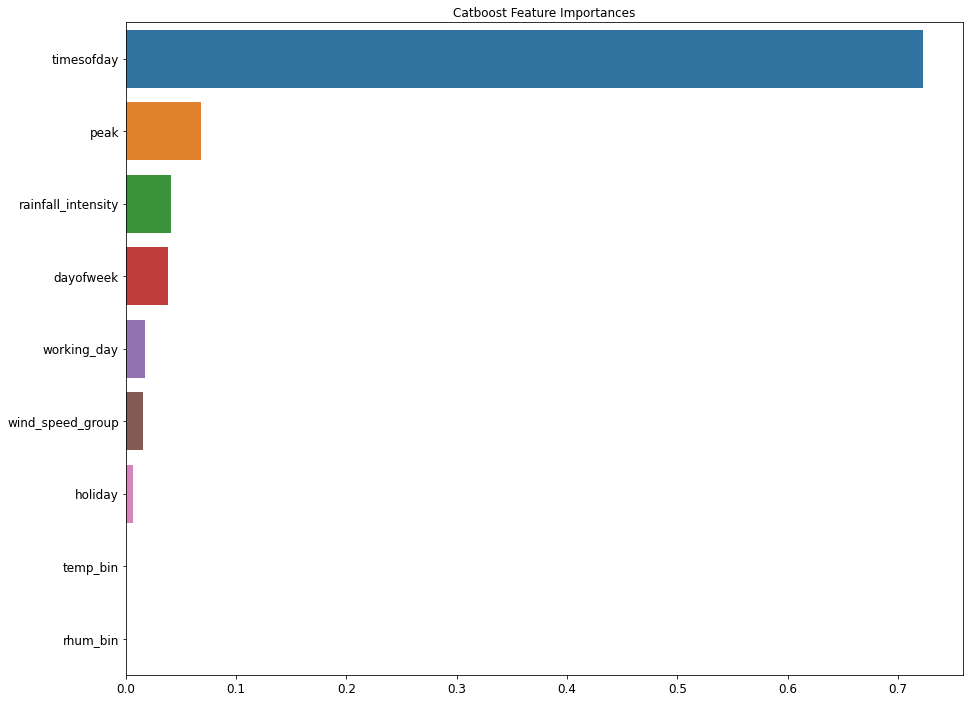

In [30]:
plot_feature_importances(model=pipe_catboost, columns=predictors,plot_title='Catboost Feature Importances')

In [31]:
learnings = \
"""Catboost model improved RSME compared to Random Forest (all cat vars) but not as good as Random Forest (temp/hum as numerical feat)."""
experiment_tracker.update_idea(idea_catboost, learnings=str.strip(learnings))

--- Idea updated! ---
ID#: 5606975808 
Idea: Catboost 
Potential Outcome: Using all features as categorical variables it will perform better using boosting trees.
Learnings: Catboost model improved RSME compared to Random Forest (all cat vars) but not as good as Random Forest (temp/hum as numerical feat).


## Support Vector Regression

In [32]:
idea_svr = et.Idea(idea='SVM Regressor', potential_outcome='SVM Regressor can be a good model for this dataset as it is a linear model and extrapolates well.')
experiment_tracker.new_idea(idea_svr)

--- New Idea added! ---
ID#: 5607631168 
Idea: SVM Regressor 
Potential Outcome: SVM Regressor can be a good model for this dataset as it is a linear model and extrapolates well.



In [33]:
from sklearn.svm import SVR

predictors = ['temp_bin','rhum_bin','holiday','dayofweek','timesofday','wind_speed_group','rainfall_intensity','peak','working_day']

params_svr = {'kernel': 'poly',
              'degree': 5,
              'gamma': 'scale',
              'C': 100
              }
# Fit a pipeline with transformers and an estimator to the training data
pipe_svr = Pipeline([
    ('preprocessor', preprocessor(predictors)),
    ('model', SVR(**params_svr))
])
train_rsme, val_rsme, train_mae, val_mae = get_train_val_score(pipe_svr, predictors)
exp_svr= et.Experiment('Support Vector Regression', predictors=predictors, hyperparameters=pipe_svr['model'].get_params(),
                               score=get_metrics_to_Experiment(), notes='')
experiment_tracker.add_experiment(exp_svr)

--- New Experiment added! ---
ID#: 5608249664 
Algorithm: Support Vector Regression 
Predictors: ['temp_bin', 'rhum_bin', 'holiday', 'dayofweek', 'timesofday', 'wind_speed_group', 'rainfall_intensity', 'peak', 'working_day']
Hyperparameters: {'C': 100, 'cache_size': 200, 'coef0': 0.0, 'degree': 5, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Date: 13/06/2022 23:23:01
Metric: [{ 'metric': RSME, 'train': 2.8928,  'validation': 2.9978, 'test': None }, { 'metric': MAE, 'train': 1.9561,  'validation': 2.0964, 'test': None }]



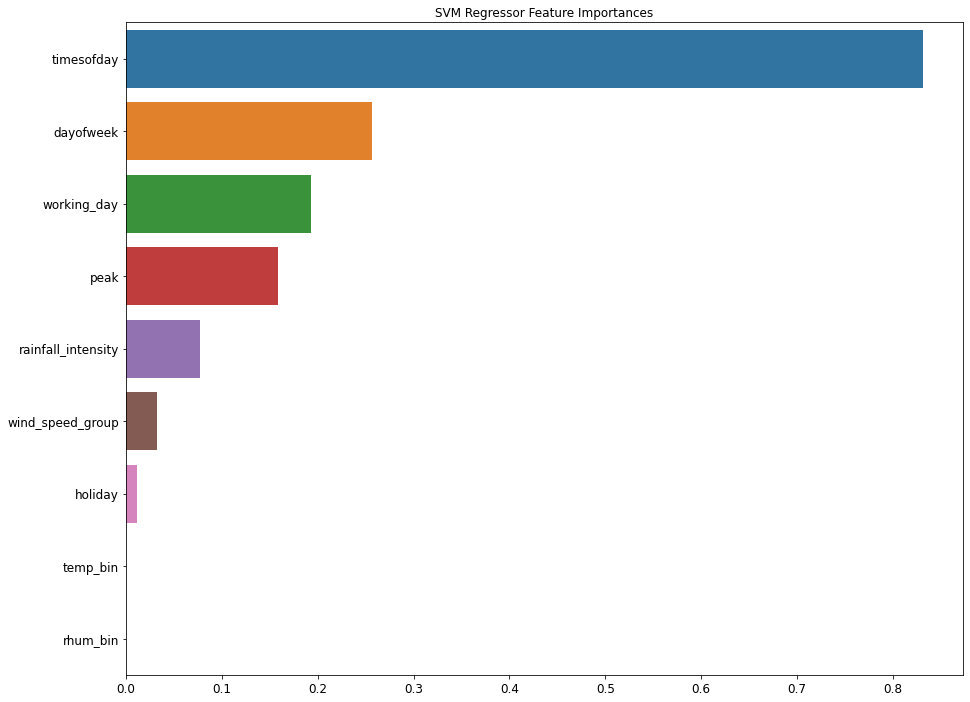

In [34]:
plot_feature_importances(model=pipe_svr, columns=predictors,plot_title='SVM Regressor Feature Importances')

In [35]:
learnings = \
"""SVM Regressor did not improve the model. Also a few features that it does not seem important on all models, now are, for example Working Day.
This model will be discarded as it is not a good model for this dataset."""
experiment_tracker.update_idea(idea_svr, learnings=str.strip(learnings))

--- Idea updated! ---
ID#: 5607631168 
Idea: SVM Regressor 
Potential Outcome: SVM Regressor can be a good model for this dataset as it is a linear model and extrapolates well.
Learnings: SVM Regressor did not improve the model. Also a few features that it does not seem important on all models, now are, for example Working Day.
This model will be discarded as it is not a good model for this dataset.


## LightGBM

In [36]:
idea_gbm = et.Idea(idea='LightGBM', potential_outcome='Another boosting tree but lighter and known to be more accurate than Catboost.')
experiment_tracker.new_idea(idea_gbm)

--- New Idea added! ---
ID#: 5608390080 
Idea: LightGBM 
Potential Outcome: Another boosting tree but lighter and known to be more accurate than Catboost.



In [37]:
predictors = ['temp_bin','rhum_bin','holiday','dayofweek','timesofday','wind_speed_group','rainfall_intensity','peak','working_day']

# LightGBM model
params_lightgbm = {'n_estimators': 100,
                   'random_state': 42,
                   'metric': 'rmse',
                   'verbose': 25
                   }

# Fit a pipeline with transformers and an estimator to the training data
pipe_lightgbm = Pipeline([
    ('preprocessor', preprocessor(predictors)),
    ('model', LGBMRegressor(**params_lightgbm))
])
train_rsme, val_rsme, train_mae, val_mae = get_train_val_score(pipe_lightgbm, predictors)
exp_lightgbm = et.Experiment('LightGBM', predictors=predictors, hyperparameters=pipe_lightgbm['model'].get_params(),
                               score=get_metrics_to_Experiment(), notes='')
experiment_tracker.add_experiment(exp_lightgbm)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.850815
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.512575
[LightGBM] [Debug] init for col-wise cost 0.012040 seconds, init for row-wise cost 0.002472 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 44
[LightGBM] [Info] Number of data points in the train set: 6132, number of used features: 19
[LightGBM] [Info] Start training from score 3.778702
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a t

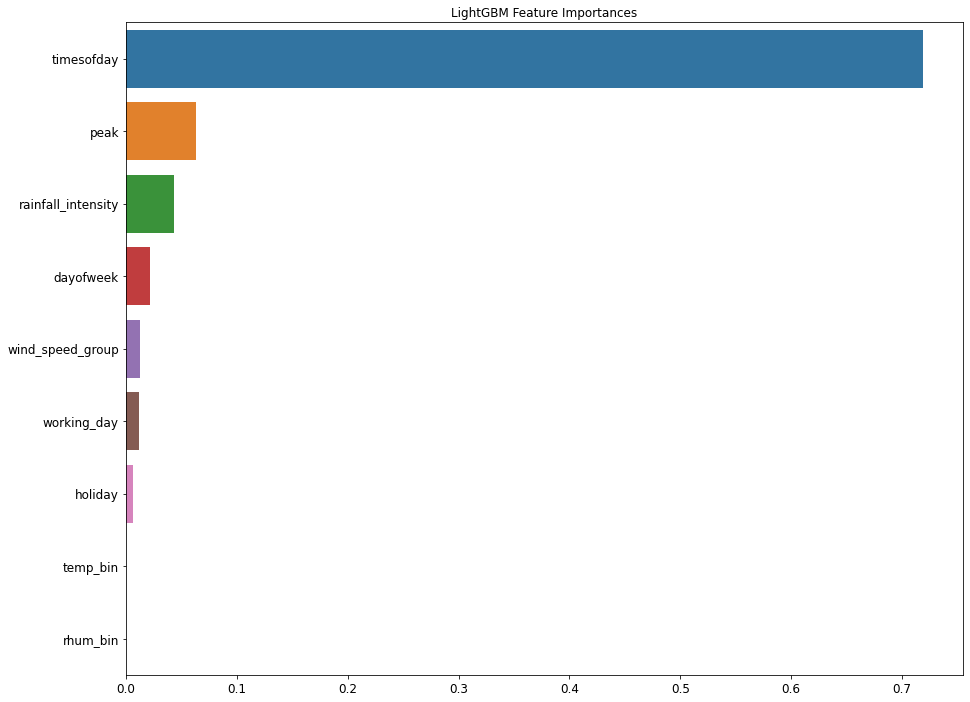

In [38]:
plot_feature_importances(model=pipe_lightgbm, columns=predictors,plot_title='LightGBM Feature Importances')

In [39]:
learnings = \
"""LightGBM model did improve the model on Validation set. The gap between the validation and training set is not large as other models."""
experiment_tracker.update_idea(idea_gbm, learnings=str.strip(learnings))

--- Idea updated! ---
ID#: 5608390080 
Idea: LightGBM 
Potential Outcome: Another boosting tree but lighter and known to be more accurate than Catboost.
Learnings: LightGBM model did improve the model on Validation set. The gap between the validation and training set is not large as other models.


In [40]:
experiment_tracker.print_partial_results()
# experiment_tracker.print_partial_results(filter_metric='rsme')

--- Experiments ---

Model: Dummy Regressor
RSME - Train: 3.6138 - Validation: 3.5840 - Test: None
MAE - Train: 2.8752 - Validation: 2.9037 - Test: None

Model: Linear Regression
RSME - Train: 3.0883 - Validation: 3.0929 - Test: None
MAE - Train: 2.3738 - Validation: 2.4021 - Test: None

Model: Random Forest (only weather features)
RSME - Train: 2.5369 - Validation: 3.0795 - Test: None
MAE - Train: 1.9659 - Validation: 2.3863 - Test: None

Model: Random Forest with all expected features
RSME - Train: 2.2489 - Validation: 2.6988 - Test: None
MAE - Train: 1.6719 - Validation: 1.9974 - Test: None

Model: Random Forest (all categoricals)
RSME - Train: 2.8120 - Validation: 2.8469 - Test: None
MAE - Train: 2.0633 - Validation: 2.1236 - Test: None

Model: Catboost model
RSME - Train: 2.8218 - Validation: 2.8131 - Test: None
MAE - Train: 2.0737 - Validation: 2.1020 - Test: None

Model: Support Vector Regression
RSME - Train: 2.8928 - Validation: 2.9978 - Test: None
MAE - Train: 1.9561 - Valida

In [41]:
idea_rf_1 = et.Idea(idea='Random Forest (wind speed numerical + estimators increased)', potential_outcome="Because temperature and humidity as numerical variables is better to RF, changing wind speed will increase model's performance.")
experiment_tracker.new_idea(idea_rf_1)

--- New Idea added! ---
ID#: 5608978080 
Idea: Random Forest (wind speed numerical + estimators increased) 
Potential Outcome: Because temperature and humidity as numerical variables is better to RF, changing wind speed will increase model's performance.



In [42]:
predictors = ['temp_r','rhum','holiday','dayofweek','timesofday','wind_speed_group','rainfall_intensity','peak','working_day']

params_rf_1 = {'n_estimators': 500,
             'max_depth': 10,
             'random_state': 42}

pipe_rf_1 = Pipeline([
    ('preprocessor', preprocessor(predictors)),
    ('model', RandomForestRegressor(**params_rf_1, criterion='squared_error'))
])
train_rsme, val_rsme, train_mae, val_mae = get_train_val_score(pipe_rf_1, predictors)
exp_rf_regr_1 = et.Experiment('Random Forest (wdsp + n_estimator = 500)', predictors=predictors, hyperparameters=pipe_rf_1['model'].get_params(),
                               score=get_metrics_to_Experiment(), notes='Changed wind speed group to numerical feature and increased n_estimators to 500.')
experiment_tracker.add_experiment(exp_rf_regr_1)

--- New Experiment added! ---
ID#: 5609545296 
Algorithm: Random Forest (wdsp + n_estimator = 500) 
Predictors: ['temp_r', 'rhum', 'holiday', 'dayofweek', 'timesofday', 'wind_speed_group', 'rainfall_intensity', 'peak', 'working_day']
Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Date: 13/06/2022 23:24:39
Metric: [{ 'metric': RSME, 'train': 2.2459,  'validation': 2.6962, 'test': None }, { 'metric': MAE, 'train': 1.6705,  'validation': 1.9971, 'test': None }]
Notes: Changed wind speed group to numerical feature and increased n_estimators to 500.


In [43]:
idea_rf_2 = et.Idea(idea='Random Forest (+ hour)', potential_outcome="Adding hour to the model will increase the model's performance because timesofday (time feature) is a good predictor.")
experiment_tracker.new_idea(idea_rf_2)

--- New Idea added! ---
ID#: 5609655552 
Idea: Random Forest (+ hour) 
Potential Outcome: Adding hour to the model will increase the model's performance because timesofday (time feature) is a good predictor.



In [44]:
predictors = ['temp_r','rhum','holiday','dayofweek','timesofday','wind_speed_group','rainfall_intensity','peak','working_day', 'hour']

params_rf_2 = {'n_estimators': 500,
             'max_depth': 10,
             'random_state': 42}

pipe_rf_2 = Pipeline([
    ('preprocessor', preprocessor(predictors)),
    ('model', RandomForestRegressor(**params_rf_2, criterion='squared_error'))
])
train_rsme, val_rsme, train_mae, val_mae = get_train_val_score(pipe_rf_2, predictors)
exp_rf_regr_2 = et.Experiment('Random Forest (+ hour)', predictors=predictors, hyperparameters=pipe_rf_2['model'].get_params(),
                               score=get_metrics_to_Experiment(), notes='Added hour to the model')
experiment_tracker.add_experiment(exp_rf_regr_2)

--- New Experiment added! ---
ID#: 5608389312 
Algorithm: Random Forest (+ hour) 
Predictors: ['temp_r', 'rhum', 'holiday', 'dayofweek', 'timesofday', 'wind_speed_group', 'rainfall_intensity', 'peak', 'working_day', 'hour']
Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Date: 13/06/2022 23:24:58
Metric: [{ 'metric': RSME, 'train': 2.2166,  'validation': 2.6178, 'test': None }, { 'metric': MAE, 'train': 1.6162,  'validation': 1.9108, 'test': None }]
Notes: Added hour to the model


In [45]:
learnings = \
"""Adding hour to the model did improve the model. Not substantially better than the previous model though."""
experiment_tracker.update_idea(idea_rf_2, learnings=str.strip(learnings))

--- Idea updated! ---
ID#: 5609655552 
Idea: Random Forest (+ hour) 
Potential Outcome: Adding hour to the model will increase the model's performance because timesofday (time feature) is a good predictor.
Learnings: Adding hour to the model did improve the model. Not substantially better than the previous model though.


In [46]:
idea_rf = et.Idea(idea='Random Forest (+ season and wdsp)', potential_outcome="Adding season and changing wind speed to numerical to the model will increase the model's performance.")
experiment_tracker.new_idea(idea_rf)

predictors = ['temp_r','rhum','holiday','dayofweek','timesofday','wdsp','rainfall_intensity','peak','working_day', 'hour', 'season']

params_rf = {'n_estimators': 500,
             'max_depth': 10,
             'random_state': 42}

pipe_rf = Pipeline([
    ('preprocessor', preprocessor(predictors)),
    ('model', RandomForestRegressor(**params_rf, criterion='squared_error'))
])
train_rsme, val_rsme, train_mae, val_mae = get_train_val_score(pipe_rf, predictors)
exp_rf_regr = et.Experiment('Random Forest (+ season and wdsp)', predictors=predictors, hyperparameters=pipe_rf['model'].get_params(),
                               score=get_metrics_to_Experiment(), notes='Added season and wdsp to the model')
experiment_tracker.add_experiment(exp_rf_regr)

--- New Idea added! ---
ID#: 5610183408 
Idea: Random Forest (+ season and wdsp) 
Potential Outcome: Adding season and changing wind speed to numerical to the model will increase the model's performance.

--- New Experiment added! ---
ID#: 5608979664 
Algorithm: Random Forest (+ season and wdsp) 
Predictors: ['temp_r', 'rhum', 'holiday', 'dayofweek', 'timesofday', 'wdsp', 'rainfall_intensity', 'peak', 'working_day', 'hour', 'season']
Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Date: 13/06/2022 23:25:11
Metric: [{ 'metric': RSME, 'train': 2.1403,  'validation': 2.5615, 'test': None }, { 'metric': MAE, 'train': 1.5528,  'validation': 1.8607, 'te

In [47]:
learnings = \
"""Adding season and changing wind speed to numerical did improve the model."""
experiment_tracker.update_idea(idea_rf, learnings=str.strip(learnings))

--- Idea updated! ---
ID#: 5610183408 
Idea: Random Forest (+ season and wdsp) 
Potential Outcome: Adding season and changing wind speed to numerical to the model will increase the model's performance.
Learnings: Adding season and changing wind speed to numerical did improve the model.


In [48]:
idea_rf = et.Idea(idea='Random Forest (max_features: sqrt)', potential_outcome="Changing the number of features to consider when looking for the best split to sqrt(n_features) can increase the performance.")
experiment_tracker.new_idea(idea_rf)

predictors = ['temp_r','rhum','holiday','dayofweek','timesofday','wdsp','rainfall_intensity','peak','working_day', 'hour', 'season']

params_rf = {'n_estimators': 500,
             'max_depth': 10,
             'max_features': 'sqrt',
             'random_state': 42}

pipe_rf = Pipeline([
    ('preprocessor', preprocessor(predictors)),
    ('model', RandomForestRegressor(**params_rf, criterion='squared_error'))
])
train_rsme, val_rsme, train_mae, val_mae = get_train_val_score(pipe_rf, predictors)
exp_rf_regr = et.Experiment('Random Forest (max_features: sqrt', predictors=predictors, hyperparameters=pipe_rf['model'].get_params(),
                               score=get_metrics_to_Experiment(), notes='Changed number of features to sqrt')
experiment_tracker.add_experiment(exp_rf_regr)

--- New Idea added! ---
ID#: 5610536912 
Idea: Random Forest (max_features: sqrt) 
Potential Outcome: Changing the number of features to consider when looking for the best split to sqrt(n_features) can increase the performance.

--- New Experiment added! ---
ID#: 5606918704 
Algorithm: Random Forest (max_features: sqrt 
Predictors: ['temp_r', 'rhum', 'holiday', 'dayofweek', 'timesofday', 'wdsp', 'rainfall_intensity', 'peak', 'working_day', 'hour', 'season']
Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Date: 13/06/2022 23:25:16
Metric: [{ 'metric': RSME, 'train': 2.3515,  'validation': 2.5847, 'test': None }, { 'metric': MAE, 'train': 1.7494,  '

In [49]:
learnings = \
"""Changing hyperparameter max_features to sqrt did not improve the model."""
experiment_tracker.update_idea(idea_rf, learnings=str.strip(learnings))

--- Idea updated! ---
ID#: 5610536912 
Idea: Random Forest (max_features: sqrt) 
Potential Outcome: Changing the number of features to consider when looking for the best split to sqrt(n_features) can increase the performance.
Learnings: Changing hyperparameter max_features to sqrt did not improve the model.


In [50]:
idea_rf_grid = et.Idea(idea='Random Forest (GridSearchCV)', potential_outcome="Hyperparameter tuning with GridSearchCV")
experiment_tracker.new_idea(idea_rf_grid)

predictors = ['temp','rhum','dayofweek','timesofday','wdsp','rainfall_intensity','peak','working_day', 'hour', 'season']

params_rf_grid = {'bootstrap': [True, False],
            'max_depth': [5, 10, 20, 30],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10],
            'n_estimators': [200, 500, 800, 1000, 1400, 1800, 2000]
             }

pipe_rf_grid = Pipeline([
    ('preprocessor', preprocessor(predictors)),
    ('rf', GridSearchCV(RandomForestRegressor(random_state=42),param_grid=params_rf_grid, cv=3, scoring='neg_root_mean_squared_error', refit=True, n_jobs=-1, verbose=-1))
])
train_rsme, val_rsme, train_mae, val_mae = get_train_val_score(pipe_rf_grid, predictors)
exp_rf_regr_grid = et.Experiment('Random Forest (GridSearchCV)', predictors=predictors, hyperparameters=pipe_rf_grid['rf'].best_estimator_.get_params(),
                               score=get_metrics_to_Experiment(), notes='Hyperparameter tuning with GridSearchCV')
experiment_tracker.add_experiment(exp_rf_regr_grid)

--- New Idea added! ---
ID#: 5608268320 
Idea: Random Forest (GridSearchCV) 
Potential Outcome: Hyperparameter tuning with GridSearchCV



In [ ]:
experiment_tracker.print_partial_results(filter_model='Random Forest', filter_metric='rsme')

In [ ]:
fsdfsd

In [ ]:
# learnings = \
# """LightGBM model did improve the model on Validation set. The gap between the validation and training set is not large as other models."""
# experiment_tracker.update_idea(exp_rf_regr_1, learnings=str.strip(learnings))

In [ ]:
experiment_tracker.to_excel('experiment_tracker.xlsx')

In [ ]:
import joblib
#save your model or results
joblib.dump(pipe_rf_grid['rf'], '../models/RandomForest.pkl')

In [ ]:
%reload_ext watermark
%watermark -a "Leandro Pessini" -n -u -v -iv -w

<img title="GitHub Mark" src="./img/GitHub-Mark-64px.png" style="height: 32px; padding-right: 15px" alt="GitHub Mark" align="left"> [GitHub repository](https://github.com/pessini/moby-bikes) <br>Author: Leandro Pessini